In [1]:
import pandas as pd
import numpy as np
import requests
from pandas.io.json import json_normalize #special package in pandas
import json
import matplotlib.pyplot as plt
%matplotlib inline

In [59]:
apiKey = "fk9d7WsjQmEM0Xc4nJozT4Uu9QLy2ZdiN6wKtwxu"

# set  parameter
params = {'api_key': apiKey}

In [60]:
# sample call so we can see the structure of the json file
response = requests.post(
       r'https://api.nal.usda.gov/fdc/v1/search',
       params=params,
       json={'generalSearchInput': "apple"}
   )
    
# save to JSON
item = response.json()

In [61]:
print(item)

{'totalHits': 20040, 'currentPage': 1, 'totalPages': 401, 'pageList': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'foodSearchCriteria': {'generalSearchInput': 'apple', 'pageNumber': 1, 'numberOfResultsPerPage': 50, 'pageSize': 50, 'requireAllWords': False}, 'foods': [{'fdcId': 577849, 'description': 'APPLE', 'lowercaseDescription': 'apple', 'dataType': 'Branded', 'gtinUpc': '887434010245', 'publishedDate': '2019-04-01', 'brandOwner': 'Oneonta Trading Corporation', 'ingredients': '', 'allHighlightFields': '', 'score': 873.7642, 'foodNutrients': [{'nutrientId': 1004, 'nutrientName': 'Total lipid (fat)', 'nutrientNumber': '204', 'unitName': 'G', 'derivationCode': 'LCCD', 'derivationDescription': 'Calculated from a daily value percentage per serving size measure', 'value': 0.0}, {'nutrientId': 1087, 'nutrientName': 'Calcium, Ca', 'nutrientNumber': '301', 'unitName': 'MG', 'derivationCode': 'LCCD', 'derivationDescription': 'Calculated from a daily value percentage per serving size measure', 'value': 8

In [62]:
food_items = ['turkey', 'macaroni and cheese', 'mashed potatoes', 'bread stuffing', 'ham', 
              'sweet potato souffle', 'cranberry sauce','mixed vegetables', 'apple pie', 'pecan pie']

In [63]:
counter = 0

for food in food_items:
    counter = counter + 1
    
    response = requests.post( r'https://api.nal.usda.gov/fdc/v1/search',
        params=params,
        json={'generalSearchInput': food}
    )
    
    item = response.json()
    
    match_item = [i for i in range(len(item['foods']))]
    
    # for each match
    for i in match_item:
        # create df of food nutrients across all matches - this should look familiar! From Module 5 - Data Structures
        if i == 0: # for the first match, initialize the dataframe
            rdf = pd.json_normalize(item['foods'][i]['foodNutrients']) # convert json to data frame
        else: # for subsequent matches, create a dataframe (with a different name to be concatenated)
            df = pd.json_normalize(item['foods'][i]['foodNutrients'])
            rdf = pd.concat([rdf,df])
            
    rdf['nutrientName'].replace('Energy','Energy',inplace=True)
    rdf['nutrientName'].replace('Carbohydrate, by difference','Carbs',inplace=True)
    rdf['nutrientName'].replace('Protein','Protein',inplace=True)
    rdf['nutrientName'].replace('Fiber, total dietary','Fiber',inplace=True)
    rdf['nutrientName'].replace('Total lipid (fat)','Fat',inplace=True)
    rdf['nutrientName'].replace('Sodium, Na','Sodium',inplace=True)
    rdf['nutrientName'].replace('Fatty acids, total saturated','Sat_Fatty_Acids',inplace=True)
    rdf['nutrientName'].replace('Calcium, Ca','Calcium',inplace=True)
    rdf['nutrientName'].replace('Iron, Fe','Iron',inplace=True)
    rdf['nutrientName'].replace('Sugars, total including NLEA','Sugar',inplace=True)
    rdf['nutrientName'].replace('Cholesterol','Chol',inplace=True)
    rdf['nutrientName'].replace('Fatty acids, total trans','Trans_Fatty_Acids',inplace=True)
    rdf['nutrientName'].replace('Vitamin C, total ascorbic acid','VitaminC',inplace=True)
    rdf['nutrientName'].replace('Vitamin A, IU','VitaminA',inplace=True)
    rdf['nutrientName'].replace('Potassium, K','Potassium',inplace=True)
    rdf['nutrientName'].replace('Fatty acids, total polyunsaturated','Unsat_Fatty_Acids',inplace=True) 
    
    agg_food = rdf[['nutrientName','value']].groupby(['nutrientName']).agg('mean')
    
    # reset index
    agg_food = agg_food.reset_index()
    
    # rename columns
    agg_food.columns = ["nutrientName","Value"]    
    
    # subset data to only include the nutrients we want
    agg_food = agg_food[agg_food["nutrientName"].isin(['Energy','Carbs','Protein','Fiber','Fat'])]

     
    # set food name into a variable so we know what values each food is associated with
    agg_food["Food"] = food 
        
    # transpose the data so the nutrient values are their own columns
    new=agg_food.pivot_table(index=["Food"], columns=['nutrientName'], values='Value')
    
    # reset the index
    new.reset_index(inplace=True)
    
    # append food match to a dataframe with all foods
    if counter ==1: # initialize the df
        all_foods=new
    else:
        all_foods=pd.concat([all_foods,new]) 

In [64]:
all_foods

nutrientName,Food,Carbs,Energy,Fat,Fiber,Protein
0,turkey,6.864400,380.296875,11.239800,0.373913,17.017400
0,macaroni and cheese,20.900408,309.446154,6.498367,0.946939,6.663469
0,mashed potatoes,56.196000,296.920000,4.590612,4.112000,6.404000
0,bread stuffing,28.132600,375.338983,9.932400,2.300000,8.293800
0,ham,7.249200,244.160714,8.330400,0.328205,14.320200
0,sweet potato souffle,24.070000,226.725806,6.781600,2.642000,2.851200
0,cranberry sauce,28.553878,197.308824,0.239800,1.972917,1.543400
0,mixed vegetables,9.295800,47.489796,0.034043,2.110000,1.625000
0,apple pie,36.368000,267.440000,13.069600,2.134694,2.963400
0,pecan pie,43.926000,505.185185,24.123200,2.579592,4.574600


Text(0.5, 1.0, 'Is There an Association Between the Amount of Protein and Energy in a Food?')

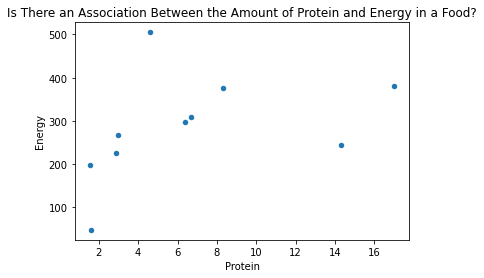

In [65]:
all_foods.plot.scatter(x='Protein',y='Energy')

# Add axis labels
plt.xlabel("Protein")
plt.ylabel("Energy")

# add title
plt.title("Is There an Association Between the Amount of Protein and Energy in a Food?")


In [66]:
# From the graph above it is easy to see that there is no relationship between the foods' energy and protein.
# The highest level of energy from the food was from a food that is 5th in protien. That is just an example,
# but if we look at the graph as hole there is no clear relationship as energy level does not increase constantly as
# the protein level is increasing and vice versa. 

Text(0.5, 1.0, 'Description of Carb Amount in the Food Item of Thanksgiving?')

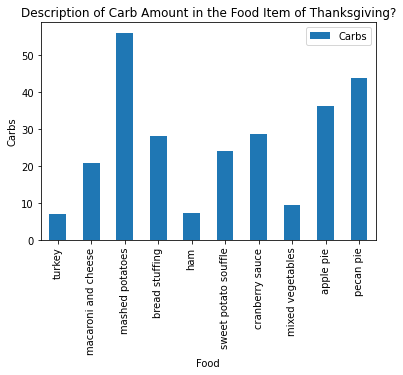

In [67]:
all_foods.plot.bar(x='Food',y='Carbs')

# Add axis labels
plt.xlabel("Food")
plt.ylabel("Carbs")

# add title
plt.title("Description of Carb Amount in the Food Item of Thanksgiving?")

In [68]:
#From the graph above it shows that when it comes to carb level among the food items, mashed potatoes have the most 
#carb amount with 56, pecan pie with second the highest amount of carb and apple pie is the third highest amount of carb. 
#And when it comes to having the lowest amount of carb it is turkey and second lowest amount carb is ham. However, half of 
#the food item is between 20 to 40. 

Text(0.5, 1.0, 'Description of Energy Amount in the Food Item of Thanksgiving?')

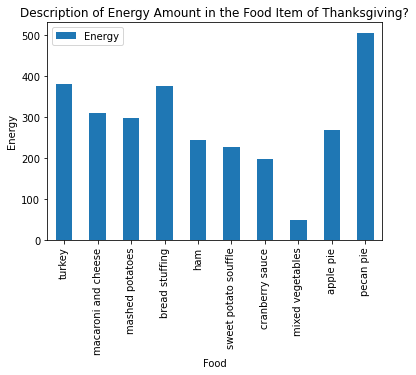

In [69]:
all_foods.plot.bar(x='Food',y='Energy')

# Add axis labels
plt.xlabel("Food")
plt.ylabel("Energy")

# add title
plt.title("Description of Energy Amount in the Food Item of Thanksgiving?")

In [70]:
#When it comes to energy level in the food items, the most energy level food among the items is pecan pie. Which is
#understandable as pecan pie is propably with the most sugar level among the items and that could contribute to the energy
#level. The second and third items is turkey and bread stuffing respectively. The least amount of energy level among them
# is the mixed vegetables. This item is the lowest by huge amount. The majority of the food items' energy amount falls 
#between 200 to 400. 

Text(0.5, 1.0, 'Description of Protein Amount in the Food Item of Thanksgiving?')

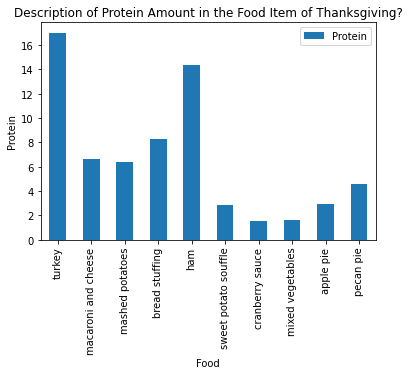

In [71]:
all_foods.plot.bar(x='Food',y='Protein')

# Add axis labels
plt.xlabel("Food")
plt.ylabel("Protein")

# add title
plt.title("Description of Protein Amount in the Food Item of Thanksgiving?")

In [72]:
#The two most highest protein amount among the food items are the meat items. Turkey has the highest amount of protein
#among the food items and ham is the second. The lowest protein amount among the food is cranberry sauce and second lowest
#is mixed vegetables. From the graph above it majority of food items are clustered from 1 to 7. 

Text(0.5, 1.0, 'Description of Fat Amount in the Food Item of Thanksgiving?')

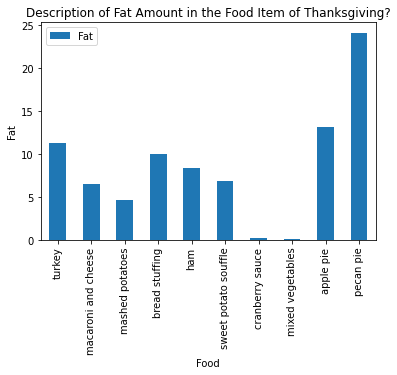

In [73]:
all_foods.plot.bar(x='Food',y='Fat')

# Add axis labels
plt.xlabel("Food")
plt.ylabel("Fat")

# add title
plt.title("Description of Fat Amount in the Food Item of Thanksgiving?")

In [74]:
#From the graph above it is easy to see that pecan pie has the most fat amount among all the food items with a huge margin. 
#The second highest among the food items is apple pie and then the third highest is turkey. Mixed vegetables has the lowest
#amount of fat and second lowes is cranberry sausce. These two items has very little amount of fat compare to other food
#items. I am not surprised at all with the graph above as I did expected for pecan pie and apple pie with the most fat 
#as these items contain a huge amount of sugar. 


Text(0.5, 1.0, 'Description of Fiber Amount in the Food Item of Thanksgiving?')

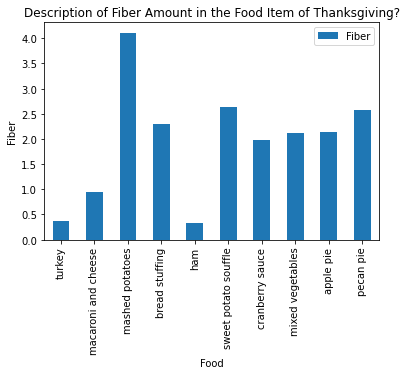

In [75]:
all_foods.plot.bar(x='Food',y='Fiber')

# Add axis labels
plt.xlabel("Food")
plt.ylabel("Fiber")

# add title
plt.title("Description of Fiber Amount in the Food Item of Thanksgiving?")

In [76]:
#The highest amount of fiber among the food is mashed potatoes and second highest is mashed potatoes and second highest 
#is sweet potato souffle. It is expected as potatoes usually have very high number of fiber. The lowest amount of fiber
#among the foods is turkey and second lowest is ham. Other food items are between 1.5 and 2.5. 

In [77]:
# It is very difficult to determine which food is the most healthy or least healthy and along with that it is also
# difficult to chose one food over another without knowing the diet of a person. 
# However, if I had to chose one I would chose Turkey as the healthiest food as it is the second highest food 
# is energy, is the most protein contain food from the list, it is also not too high in carbs and fat and low in fiber. 


In [2]:
# The least healthy food form the list is mixed vegetables. It is very ironic that vegetable is my answer as
# usually vegetables considered one of the most healthy food. However, from the graph, I see that mixed vegetables
# as least energy and protein contain food from the list. In my opinion if a food does not give enough energy and protein 
# which are two vitals necessary nutrients that foods we eat should provide. But, mixed vegetables is delievering the least
# in both categories.

In [3]:
import json
from pandas.io.json import json_normalize
fruits_str = '[{"kind":"apple", "varieties":[{"variety":"fuji"},{"variety":"jazz"}]}, {"kind":"orange", "varieties":[{"variety":"navel"}]}]' 

fruits_json = json.loads(fruits_str)

In [7]:
fruits_df = pd.json_normalize(fruits_json,record_path='varieties',meta='kind')

In [8]:
fruits_df

,variety,kind
0,fuji,apple
1,jazz,apple
2,navel,orange
